
## **Missing Value Imputation**

In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

---
## Load the data

In [302]:
input = '../data/clean-data/flats-house-cleaned-v3.csv'
output = '../data/clean-data/flats-house-cleaned-v4.csv'

df = pd.read_csv(input)
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,area_room_ratio
0,flat,emaar mgf palm hills,sector 77,1.50,12744.0,1177.0,Super Built up area 1450(134.71 sq.m.)Carpet a...,3,3,3,4.0,North-East,Relatively New,1450.0,NaN,1177.00,0,0,0,0,0,2,97,392.333333
1,flat,raheja vedaanta,sector 108,0.85,4637.0,1833.0,Super Built up area 1833(170.29 sq.m.)Built Up...,3,3,2,2.0,North-East,Relatively New,1833.0,1500.0,1350.00,0,1,0,0,0,0,65,611.000000
2,flat,511 sarahah tower,sector 12,0.60,8333.0,720.0,Carpet area: 720 (66.89 sq.m.),2,2,1,0.0,NaN,New Property,NaN,NaN,720.00,0,0,0,1,0,1,0,360.000000
3,flat,laxmi pareena,sector 99a,0.30,6667.0,450.0,Carpet area: 450 (41.81 sq.m.),2,1,0,12.0,North,Undefined,NaN,NaN,450.00,0,0,0,0,0,0,0,225.000000
4,flat,emaar gurgaon greens,sector 102,1.55,9394.0,1650.0,Super Built up area 1650(153.29 sq.m.)Carpet a...,3,4,3,7.0,North,Relatively New,1650.0,NaN,1022.58,0,1,0,0,0,2,152,550.000000


In [303]:
df.shape

(3541, 24)

In [304]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                     0
price_per_sqft            0
area                      0
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
floorNum                 17
facing                 1009
agePossession             0
super_built_up_area    1666
built_up_area          1964
carpet_area            1709
study room                0
servant room              0
store room                0
pooja room                0
others                    0
furnishing_type           0
luxury_score              0
area_room_ratio           0
dtype: int64

there are missing values in the following columns :
- `built_up_area`
- `super_built_up_area`
- `carpet_area`

- `society`

- `floorNum`
- `facing`
- `agePossession` ['undefined cateogry']








---
## Imputing `built_up_area`,with the help of `super_built_up_area`,`carpet_area` and `area`

- ``built_up_area`` and ``super_built_up_area`` relationship

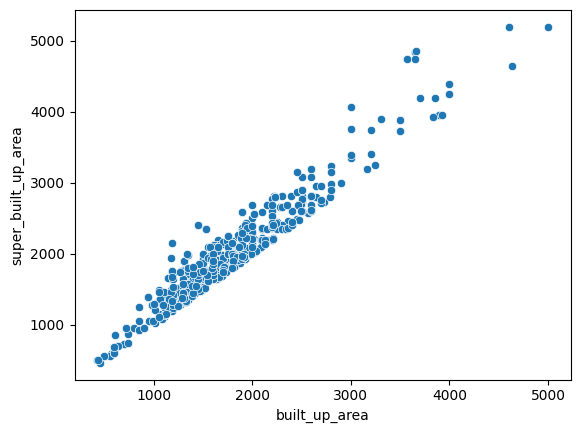

In [305]:
#  scatter plot between built_up_area and super_built_up_area
sns.scatterplot(x='built_up_area', y='super_built_up_area', data=df)
plt.show()

**Note**: We can see that there is a positive line relationship between `built_up_area` and `super_built_up_area`.

- So by drawing a line we can get the `built_up_area`. 

- becuase government decide the how much space you need to left in `super_built_up_area` to build `built_up_area`.

- ( approx 30% of `super_built_up_area` you need to left in gurgaon)


---


- ``built_up_area`` and ``carpet_area`` relationship

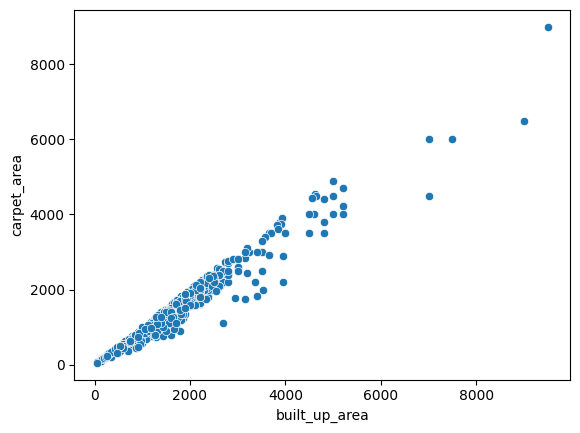

In [306]:
# scatter plot between built_up_area and carpet_area
sns.scatterplot(x = 'built_up_area', y = 'carpet_area', data=df)
plt.show()

- again you can see that there is a positive line relationship between `built_up_area` and `carpet_area`.

- so we  can get the `built_up_area` by using the `super_built_up_area` and `carpet_area`.

- Let's fill the values

In [307]:
# rows where all three columns (`super_built_up_area`,`built_up_area`,`carpet_area`) are null together.
((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))

0       False
1       False
2       False
3       False
4       False
        ...  
3536    False
3537    False
3538    False
3539    False
3540    False
Length: 3541, dtype: bool

**Observation:** Fortunately there is no row where all three columns are null together.

In [308]:
# extract rows where all three columns are available.
all_present_df = df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))]

print("\n all_present_df.shape:",all_present_df.shape)

all_present_df[['super_built_up_area','built_up_area','carpet_area']].sample(5)


 all_present_df.shape: (531, 24)


,super_built_up_area,built_up_area,carpet_area
70,1524.0,1250.0,921.0
1146,2000.0,1800.0,1500.0
2857,2436.0,2236.0,2036.0
886,1760.0,1186.0,1130.0
885,1050.0,850.0,645.0


calculating ratio of `super_built_up_area` to `built_up_area` and `carpet_area` to `built_up_area`.

- These ratios will be used to estimate missing values in other rows

- `super_to_built_up_ratio` can be used to estimate `built_up_area` from `super_built_up_area`

- `carpet_to_built_up_ratio` can be used to estimate `built_up_area` from `carpet_area`

In [309]:
# Calculate the median ratio of super built-up area to built-up area
super_to_built_up_ratio = (all_present_df['super_built_up_area'] / all_present_df['built_up_area']).median()

# Calculate the median ratio of carpet area to built-up area
carpet_to_built_up_ratio = (all_present_df['carpet_area'] / all_present_df['built_up_area']).median()

print(f"super_to_built_up_ratio: {super_to_built_up_ratio}")
print(f"carpet_to_built_up_ratio: {carpet_to_built_up_ratio}")


super_to_built_up_ratio: 1.105263157894737
carpet_to_built_up_ratio: 0.9


- extracting rows where both `super_built_up_area` and `carpet_area` is present but  `built_up_area` is null 

In [310]:
# both present , but built_up_area  is null
sbc_df = df[~(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & ~(df['carpet_area'].isnull())]

print(f"sbc_df.shape: {sbc_df.shape}")
sbc_df.head()

sbc_df.shape: (421, 24)


,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,area_room_ratio
0,flat,emaar mgf palm hills,sector 77,1.50,12744.0,1177.0,Super Built up area 1450(134.71 sq.m.)Carpet a...,3,3,3,4.0,North-East,Relatively New,1450.0,NaN,1177.00,0,0,0,0,0,2,97,392.333333
4,flat,emaar gurgaon greens,sector 102,1.55,9394.0,1650.0,Super Built up area 1650(153.29 sq.m.)Carpet a...,3,4,3,7.0,North,Relatively New,1650.0,NaN,1022.58,0,1,0,0,0,2,152,550.000000
7,flat,emaar mgf palm hills,sector 77,1.90,9500.0,2000.0,Super Built up area 2000(185.81 sq.m.)Carpet a...,3,4,3+,6.0,South-West,New Property,2000.0,NaN,1218.03,0,1,0,0,0,2,42,666.666667
8,flat,signature global the millennia,sector 37d,0.65,10906.0,596.0,Super Built up area 650(60.39 sq.m.)Carpet are...,2,2,3,0.0,NaN,New Property,650.0,NaN,596.00,0,0,0,0,0,0,40,298.000000
9,flat,tarc maceo,sector 91,1.75,11118.0,1574.0,Super Built up area 2724(253.07 sq.m.)Carpet a...,4,3,3+,8.0,South,Relatively New,2724.0,NaN,1573.59,1,1,1,1,0,0,128,393.500000


Imputation logic  : Now We can fill the 421 rows of  `built_up_area` with the median of `super_built_up_area` and `carpet_area`

imputaion formula : average of (sbc_df['super_built_up_area']/1.105) + (sbc_df['carpet_area']/0.9)

In [311]:
# Calculate the imputed values for built_up_area
imputed_values = round(((sbc_df['super_built_up_area']/1.105) + (sbc_df['carpet_area']/0.9))/2)

# Assign the imputed values to built_up_area
sbc_df = sbc_df.assign(built_up_area=lambda x: x['built_up_area'].fillna(imputed_values))

In [312]:
# update the dataframe with the imputed values
df.update(sbc_df)

# check again how much value are imputed in built_up_area
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                     0
price_per_sqft            0
area                      0
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
floorNum                 17
facing                 1009
agePossession             0
super_built_up_area    1666
built_up_area          1543
carpet_area            1709
study room                0
servant room              0
store room                0
pooja room                0
others                    0
furnishing_type           0
luxury_score              0
area_room_ratio           0
dtype: int64

---

- extracting rows where  `super_built_up_area` is present but `carpet_area` is null and  `built_up_area` is null 

In [313]:
# super_built_up_area present, carpet_area is null, built_up_area is null
sb_df = df[~(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())]

print(f"sb_df.shape: {sb_df.shape}")

sb_df.head()

sb_df.shape: (875, 24)


,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,area_room_ratio
5,flat,mapsko royale ville,sector 82,0.97,5419.0,1790.0,Super Built up area 1790(166.3 sq.m.),3,4,2,16.0,North-West,Relatively New,1790.0,NaN,NaN,0,1,0,0,0,0,95,596.666667
6,flat,aipl the peaceful homes,sector 70a,2.40,11163.0,2150.0,Super Built up area 2150(199.74 sq.m.),3,3,3,11.0,South-West,Relatively New,2150.0,NaN,NaN,0,1,0,0,0,0,108,716.666667
12,flat,ireo victory valley,sector 67,4.55,14537.0,3130.0,Super Built up area 3130(290.79 sq.m.),4,4,3+,19.0,South,Relatively New,3130.0,NaN,NaN,0,1,0,0,0,2,156,782.500000
15,flat,godrej aria,sector 79,1.10,11482.0,958.0,Super Built up area 89,2,2,3,9.0,NaN,New Property,89.0,NaN,NaN,0,0,0,0,0,0,62,479.000000
27,flat,paras quartier,gwal pahari,5.90,11028.0,5350.0,Super Built up area 5350(497.03 sq.m.),4,4,3+,19.0,East,New Property,5350.0,NaN,NaN,1,1,1,1,0,2,160,1337.500000


- imputation formula : `built_up_area` = `super_built_up_area`/1.105

In [314]:
# impute the built_up_area with the median of `super_built_up_area`
sb_df.loc[:, 'built_up_area'] = round(sb_df['super_built_up_area'] / 1.105)


In [315]:
# Update the main dataframe with the imputed values from sb_df
df.update(sb_df)

# Check the number of null values in each column after the update
# This helps us verify if the imputation reduced the number of nulls in built_up_area
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                     0
price_per_sqft            0
area                      0
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
floorNum                 17
facing                 1009
agePossession             0
super_built_up_area    1666
built_up_area           668
carpet_area            1709
study room                0
servant room              0
store room                0
pooja room                0
others                    0
furnishing_type           0
luxury_score              0
area_room_ratio           0
dtype: int64

**Note** :  Now only 668 row is left in `built_up_area` which is null.

---

In [316]:
# carpet area is present, super_built_up_area is null, built_up_area is null
c_df = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & ~(df['carpet_area'].isnull())]

print(f"c_df.shape: {c_df.shape}")

c_df.head()

c_df.shape: (668, 24)


,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score,area_room_ratio
2,flat,511 sarahah tower,sector 12,0.60,8333.0,720.0,Carpet area: 720 (66.89 sq.m.),2,2,1,0.0,NaN,New Property,NaN,NaN,720.0,0,0,0,1,0,1,0,360.00
3,flat,laxmi pareena,sector 99a,0.30,6667.0,450.0,Carpet area: 450 (41.81 sq.m.),2,1,0,12.0,North,Undefined,NaN,NaN,450.0,0,0,0,0,0,0,0,225.00
16,flat,paras dews,sector 106,1.35,8940.0,1510.0,Carpet area: 1510 (140.28 sq.m.),4,3,3,19.0,NaN,Old Property,NaN,NaN,1510.0,0,1,0,0,0,0,112,377.50
18,flat,tulip monsella,sector 53,7.40,33199.0,2229.0,Carpet area: 2229 (207.08 sq.m.),4,4,3,21.0,NaN,Under Construction,NaN,NaN,2229.0,0,0,0,0,0,0,35,557.25
21,flat,signature the roselia,sector 95,0.45,7909.0,569.0,Carpet area: 569 (52.86 sq.m.),2,2,2,2.0,East,New Property,NaN,NaN,569.0,0,0,0,0,0,2,31,284.50


- Imputation formula : `built_up_area` = `carpet_area`/0.9

In [317]:
# impute the built_up_area with the median of `carpet_area`
c_df.loc[:, 'built_up_area'] = round(c_df['carpet_area'] / 0.9)

In [318]:
# update the main dataframe with the imputed values from c_df
df.update(c_df)

# check the number of null values in each column after the update
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                     0
price_per_sqft            0
area                      0
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
floorNum                 17
facing                 1009
agePossession             0
super_built_up_area    1666
built_up_area             0
carpet_area            1709
study room                0
servant room              0
store room                0
pooja room                0
others                    0
furnishing_type           0
luxury_score              0
area_room_ratio           0
dtype: int64

**NOTE** : `built_up_area` have 0 null values now.

---

### `built_up_area` Vs `price`

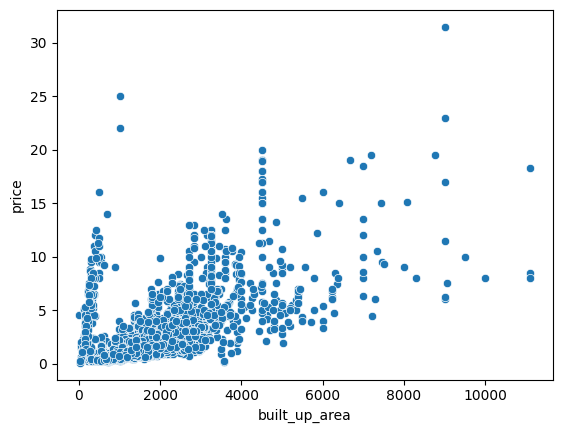

In [319]:
sns.scatterplot(x = 'built_up_area', y='price',data=df)
plt.show()


As you can see there is a positive linear relationship between `built_up_area` and `price` , but there is some anamoly in the data[area < 2000 and price > 2.5]

Let's fix this anamoly by imputing the `built_up_area` with the `area`



In [320]:
# extract rows where `built_up_area` is less than 2000 and `price` is greater than 2.5
anamoly_df = df[(df['built_up_area'] < 2000) & (df['price'] > 2.5)][['price','area','built_up_area']]

print(f"anamoly_df.shape: {anamoly_df.shape}")

anamoly_df.sample(5)

anamoly_df.shape: (275, 3)


,price,area,built_up_area
3192,6.50,1800.000000,1800.0
193,4.00,7382.165283,981.0
345,3.40,2185.000000,1977.0
525,3.75,1701.000000,1701.0
284,12.00,3240.000000,400.0


**Observation** : `price` is justfied by `area` , but not with `built_up_area`.

- so we can impute the `built_up_area` with the `area`


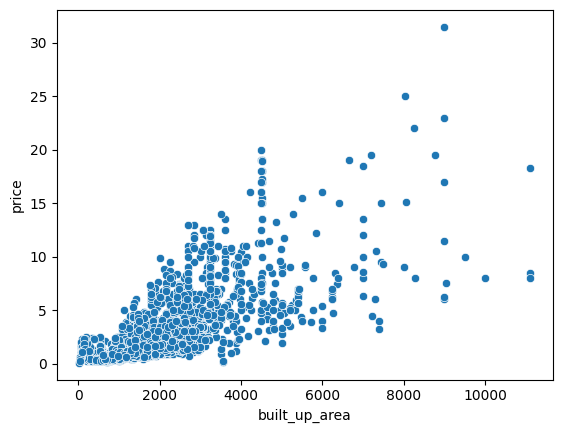

In [321]:
# impute the `built_up_area` with the `area`
anamoly_df['built_up_area'] = anamoly_df['area']
df.update(anamoly_df)

sns.scatterplot(x = df['built_up_area'], y =df['price'], data=df)
plt.show()

**Observation** : Now You can see that the scatter plot is linear. No anamoly is there.

---

Now we can drop the `area`,`areaWithType`,`super_built_up_area`,`carpet_area`,`area_room_ratio` from the dataframe.

In [322]:
df.drop(columns=['area','areaWithType','super_built_up_area','carpet_area','area_room_ratio'],inplace=True)

print(f"df.shape: {df.shape}")

df.head()

df.shape: (3541, 19)


,property_type,society,sector,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,facing,agePossession,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,flat,emaar mgf palm hills,sector 77,1.50,12744.0,3,3,3,4.0,North-East,Relatively New,1310.0,0,0,0,0,0,2,97
1,flat,raheja vedaanta,sector 108,0.85,4637.0,3,3,2,2.0,North-East,Relatively New,1500.0,0,1,0,0,0,0,65
2,flat,511 sarahah tower,sector 12,0.60,8333.0,2,2,1,0.0,NaN,New Property,800.0,0,0,0,1,0,1,0
3,flat,laxmi pareena,sector 99a,0.30,6667.0,2,1,0,12.0,North,Undefined,500.0,0,0,0,0,0,0,0
4,flat,emaar gurgaon greens,sector 102,1.55,9394.0,3,4,3,7.0,North,Relatively New,1315.0,0,1,0,0,0,2,152


In [323]:
df.isnull().sum()

property_type         0
society               1
sector                0
price                 0
price_per_sqft        0
bedRoom               0
bathroom              0
balcony               0
floorNum             17
facing             1009
agePossession         0
built_up_area         0
study room            0
servant room          0
store room            0
pooja room            0
others                0
furnishing_type       0
luxury_score          0
dtype: int64

---
## Imputing `floorNum`

- There are 17 rows where `floorNum` is null.

In [324]:
# extract rows where `floorNum` is null
df[df['floorNum'].isnull()]

,property_type,society,sector,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,facing,agePossession,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
378,house,ansal sushant lok,sector 43,10.50,27911.0,4,4,2,NaN,North-East,Old Property,3762.0,0,1,0,0,0,0,59
391,house,independent,sector 26,4.60,12198.0,4,4,3+,NaN,NaN,Old Property,3771.0,0,0,0,0,0,0,28
665,house,independent,sector 3,1.50,10288.0,3,3,0,NaN,NaN,Old Property,210.0,0,0,0,0,0,0,0
804,flat,experion heartsong,dwarka expressway,1.08,6150.0,3,3,0,NaN,NaN,Under Construction,1758.0,0,0,0,0,0,0,0
1045,house,vipul tatvam villa,sector 48,8.50,26235.0,4,4,2,NaN,East,Moderately Old,3240.0,0,1,1,1,0,0,88
1315,house,independent,sector 4,4.12,8889.0,2,1,3+,NaN,NaN,Moderately Old,4635.0,0,0,0,0,0,0,0
1454,house,dlf new town heights,sector 86,2.47,7719.0,4,4,3+,NaN,West,Moderately Old,2800.0,0,1,0,1,0,2,130
1478,house,vipul tatvam villa,sector 48,8.50,26235.0,4,4,1,NaN,NaN,Relatively New,3240.0,0,0,0,0,0,0,21
1763,house,independent,sector 7,6.50,15046.0,3,2,3+,NaN,NaN,Old Property,4320.0,0,0,0,0,0,0,9
2462,house,jacob pura,sector 12,0.35,9722.0,2,1,0,NaN,NaN,Old Property,360.0,0,0,0,0,0,0,0


`property_type` is the column which decide the `floorNum`

Generally ,
 
- house have 1,2,3 and 4 `floor`.

- flat have higher `floor`.

- Imputate the `floorNum` with the median of `floorNum` for `house`.

- This approach assumes that
houses typically have 1-4 floors, and uses the median as a reasonable
estimate for missing values. 

- However, it might be worth considering
different imputation strategies for flats vs houses in future iterations.

In [325]:
# Calculate the median floor number for houses
median_floor_house = df[df['property_type'] == 'house']['floorNum'].median()

df['floorNum'] = df['floorNum'].fillna(median_floor_house)

# Check for any remaining null values in the dataframe
df.isnull().sum()


property_type         0
society               1
sector                0
price                 0
price_per_sqft        0
bedRoom               0
bathroom              0
balcony               0
floorNum              0
facing             1009
agePossession         0
built_up_area         0
study room            0
servant room          0
store room            0
pooja room            0
others                0
furnishing_type       0
luxury_score          0
dtype: int64

- Now You can see that `floorNum` have 0 null values.


---
## Imputing `facing`


Percentage of null values in facing: 28.49%


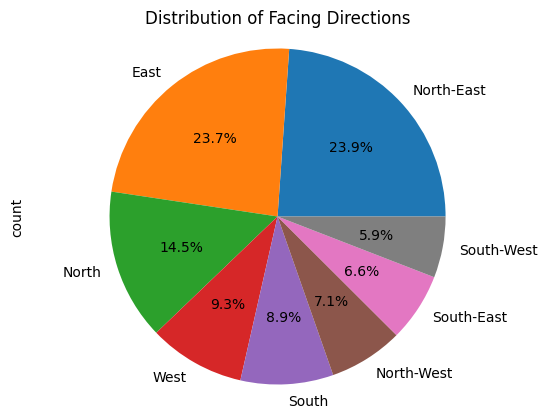

In [326]:
# Calculate the percentage of null values in 'facing' column
null_percentage = (df['facing'].isnull().sum() / df.shape[0]) * 100

print(f"Percentage of null values in facing: {null_percentage:.2f}%")

# Plot the value counts of non-null values in 'facing' column
df['facing'].dropna().value_counts().plot(kind='pie', autopct='%0.1f%%')
plt.title('Distribution of Facing Directions')
plt.axis('equal') 
plt.show()

- Around 28 % value in facing column is null.
- we can't impute the facing column with the help of other columns.
- so we can drop the facing column.

In [327]:
df.drop(columns=['facing'],inplace=True)
df.sample(5)

,property_type,society,sector,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,agePossession,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2269,flat,ireo the grand arch,sector 58,3.80,17560.0,3,4,1,19.0,Moderately Old,2164.0,0,1,0,0,0,2,167
2639,flat,ss the leaf,sector 85,1.18,10094.0,2,3,3,12.0,Relatively New,1420.0,0,0,0,1,0,2,150
3256,flat,godrej nature plus,sector 33,1.65,8267.0,3,3,3,2.0,Under Construction,2218.0,0,1,0,0,0,0,37
1744,house,international city by sobha phase 1,sector 109,6.10,25103.0,5,6,3+,2.0,Moderately Old,2430.0,0,1,0,0,0,0,30
2250,flat,emaar gurgaon greens,sector 102,1.40,8485.0,3,3,3,9.0,Relatively New,1413.0,0,1,0,0,0,0,49


In [328]:
df.isnull().sum()

property_type      0
society            1
sector             0
price              0
price_per_sqft     0
bedRoom            0
bathroom           0
balcony            0
floorNum           0
agePossession      0
built_up_area      0
study room         0
servant room       0
store room         0
pooja room         0
others             0
furnishing_type    0
luxury_score       0
dtype: int64

---
## Imputing `society`
- society column have 1 null value. and there are lots of society name in the column.  
- We can fill with mode of society column. but now we can drop the row.



In [329]:
# find the index of the row where society is null
index_to_drop = df[df['society'].isnull()].index

# drop the row
df.drop(index=index_to_drop, inplace=True)
df.isnull().sum()


property_type      0
society            0
sector             0
price              0
price_per_sqft     0
bedRoom            0
bathroom           0
balcony            0
floorNum           0
agePossession      0
built_up_area      0
study room         0
servant room       0
store room         0
pooja room         0
others             0
furnishing_type    0
luxury_score       0
dtype: int64

- Now you can no null value .

- but `agePossession` column have some undefined category. , lets fill the undefined category

---
## Imputing `agePossession`

In [330]:
df['agePossession'].value_counts()

agePossession
Relatively New        1601
New Property           555
Moderately Old         541
Old Property           291
Undefined              290
Under Construction     262
Name: count, dtype: int64

**Observation** : There are 290 undefined category in the `agePossession` column.

Since agepossesion is undefined , it does not tell that a property is new or old or under construction.

- So we can treat this as missing value.

In [331]:
# extract rows where `agePossession` is undefined
df[df['agePossession'] == 'Undefined']

,property_type,society,sector,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,agePossession,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
3,flat,laxmi pareena,sector 99a,0.30,6667.0,2,1,0,12.0,Undefined,500.0,0,0,0,0,0,0,0
11,house,independent,sector 9,1.65,18333.0,2,3,0,3.0,Undefined,900.0,0,0,0,0,0,0,0
33,flat,eldeco accolade,sector 33,1.20,8043.0,2,2,2,0.0,Undefined,1492.0,0,0,0,0,0,0,56
37,flat,central park flower valley,sector 33,2.50,13270.0,3,3,2,1.0,Undefined,2093.0,0,0,0,0,0,0,66
47,flat,ramprastha the edge towers,sector 37d,1.10,5528.0,3,3,3,9.0,Undefined,1990.0,0,0,0,0,0,0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,house,independent,sector 9,0.22,7407.0,2,2,2,1.0,Undefined,37.0,0,0,0,0,0,0,0
3484,flat,ansal height 86,sector 86,0.80,5882.0,2,2,0,1.0,Undefined,1360.0,0,0,0,0,0,0,0
3495,house,independent,sector 108,1.34,5000.0,1,1,0,1.0,Undefined,2680.0,0,0,0,0,0,0,0
3511,house,independent,sector 67,3.00,11905.0,4,4,0,3.0,Undefined,2800.0,0,0,0,0,0,0,0


We can fill the undefined category with the mode of `agePossession` for that `sector` and `property_type`. We can prove this relation with statistic test.

In [332]:
# Function to impute 'Undefined' values in 'agePossession' column

def mode_based_imputation1(row):

    # Check if the current row's 'agePossession' is 'Undefined'
    if row['agePossession'] == 'Undefined':
        # Find the mode of 'agePossession' for the same sector and property type
        mode_value = df[(df['sector'] == row['sector']) & (df['property_type'] == row['property_type'])]['agePossession'].mode()

        # If a mode is found, return it; otherwise, return NaN
        if not mode_value.empty:
            return mode_value.iloc[0] 
        else:
            return np.nan
    else:
        # If 'agePossession' is not 'Undefined', return the original value
        return row['agePossession']

In [333]:
# apply the mode_based_imputation1 function to the dataframe
df['agePossession'] = df.apply(mode_based_imputation1,axis=1)
df['agePossession'].value_counts()

agePossession
Relatively New        1717
New Property           594
Moderately Old         580
Old Property           322
Under Construction     276
Undefined               51
Name: count, dtype: int64

- There are still 51 undefined category in the `agePossession` column.

---

- This function imputes 'Undefined' values in the 'agePossession' column, based on the mode of 'agePossession' for the same sector

In [334]:
def mode_based_imputation2(row):
    if row['agePossession'] == 'Undefined':
        # Find the mode of 'agePossession' for the same sector
        mode_value = df[(df['sector'] == row['sector'])]['agePossession'].mode()
        
        # If a mode is found, return it; otherwise, return NaN
        if not mode_value.empty:
            return mode_value.iloc[0] 
        else:
            return np.nan
    else:
        # If 'agePossession' is not 'Undefined', return the original value
        return row['agePossession']


In [335]:
# apply the mode_based_imputation2 function to the dataframe
df['agePossession'] = df.apply(mode_based_imputation2,axis=1)
df['agePossession'].value_counts()

agePossession
Relatively New        1728
New Property           595
Moderately Old         586
Old Property           325
Under Construction     278
Undefined               28
Name: count, dtype: int64

- There are still 28 undefined category in the `agePossession` column.

---

- This function imputes 'Undefined' values in the 'agePossession' column
,based on the mode of 'agePossession' for the same property type

In [336]:
def mode_based_imputation3(row):
    if row['agePossession'] == 'Undefined':
        # Find the mode of 'agePossession' for the same property type
        mode_value = df[(df['property_type'] == row['property_type'])]['agePossession'].mode()
        
        # If a mode is found, return it; otherwise, return NaN
        if not mode_value.empty:
            return mode_value.iloc[0] 
        else:
            return np.nan
    else:
        # If 'agePossession' is not 'Undefined', return the original value
        return row['agePossession']


In [337]:
df['agePossession'] = df.apply(mode_based_imputation3,axis=1)
df['agePossession'].value_counts()

agePossession
Relatively New        1728
Moderately Old         614
New Property           595
Old Property           325
Under Construction     278
Name: count, dtype: int64

Now you can see there is no undefined `agePossession` catogory

---

In [338]:
print(f"df.shape: {df.shape}")

df.isnull().sum()

df.shape: (3540, 18)


property_type      0
society            0
sector             0
price              0
price_per_sqft     0
bedRoom            0
bathroom           0
balcony            0
floorNum           0
agePossession      0
built_up_area      0
study room         0
servant room       0
store room         0
pooja room         0
others             0
furnishing_type    0
luxury_score       0
dtype: int64

In [339]:
df.to_csv(output,index=False)

**Next Step** : feature Selection

**END**

---